In [1]:
import glob
import gdal
import osr
import os
import datetime as dt
import numpy as np
import scipy.stats
import sklearn
from PIL import Image
from matplotlib.colors import ListedColormap
from IPython.display import SVG, display
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

import warnings
warnings.filterwarnings('ignore')

# Door-to-Door ML Classifier tutorial
When training a machine learning algorthm, the first step is build a labelled feature space. This is a 2D array of EO data with associated labels showing which landcover class each row belongs to. This means opening data for each know patch of landcover in the scene, creating composites of various reflectance and indicies and then maniulating the arrays to fit the format the machine learning can use. The algorthms can then be trained, applied to the whole scene and optimized to achieve the best results

## Section 1 - Underlying tools for Feature Space Generation
This section will show how we use the specific tools needed to generate the feature space. We will cover the use of a complex gdal function, which is very helpful when openeing datasets of differet types and resolutions. Then, the cloudmasking algorthm covered on Day 1 will be applied, as well as how to build a function which automatically generates spectral indexes and aggregates data into composites.

Text(0.5, 1.0, 'Data openening using a shapefile to subset data')

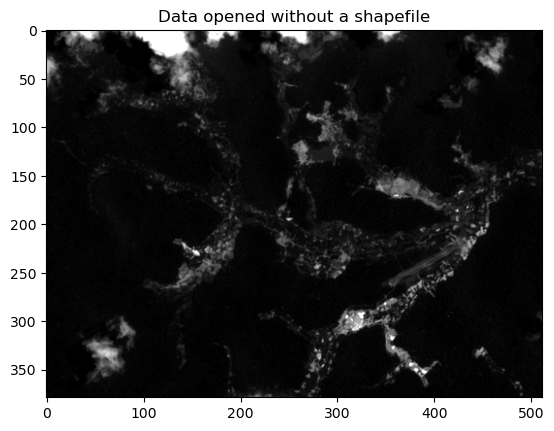

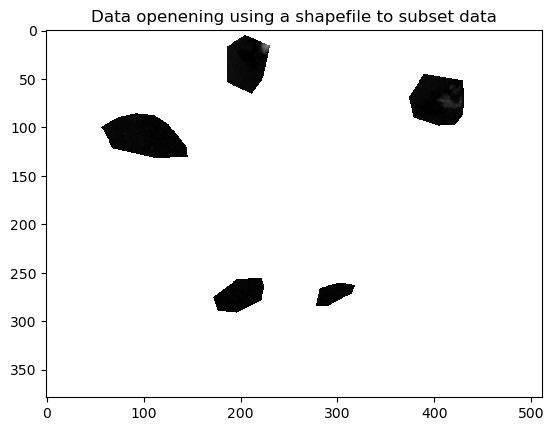

In [2]:
# when opening raster data with a shapefile to spatially subset
# the data, it is easy to use gdal.Warp to do this

# to show how this can work, we will experiment with this 
# functionality

# firstly open the dataset without any masking
test_file = '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-09.tif'
opn_v1 = gdal.Open(test_file)
# open the Dataset to get to the array 
arr_v1 = opn_v1.ReadAsArray()

# next, lets open the dataset and mask everything
# not in one of the shapefile geometries
no_dataval = 0
test_shapefile = '/media/DataShare/Alex/un_surinam/forest.shp'

# do the warping with the following command
opn_v2 = gdal.Warp('',test_file,format='MEM',
                  cutlineDSName = test_shapefile,
                  cropToCutline = False,
                  dstNodata = no_dataval)
arr_v2 = opn_v2.ReadAsArray()

# next, we need to recast the datatype to np.float32
# so we can set values to np.nan
arr_v2 = arr_v2.astype(np.float32)

# next, set the value outside the geometries to np.nan
arr_v2[arr_v2 == no_dataval] = np.nan

plt.figure()
plt.imshow(arr_v1[0],vmax=3000,vmin=300)
plt.title('Data opened without a shapefile')

plt.figure()
plt.imshow(arr_v2[0],vmax=3000,vmin=300)
plt.title('Data openening using a shapefile to subset data')

To open data, we will use a complex function that can use a shapefile as well as reproject and resample data, so that the data being opened can fit onto the grid of another file. This is essential, so that we can open everything to have the same spatial arrangements and sorted properly.

The function we will be using is 'reproject_image' from the helper file. Dont worry about the inner mechanics of this function, but it is good to understand what it does and how it effects the opened data

In [3]:
from day3_helpers import reproject_image

To show the power of this function, we will open some Sentinel 2 Band 12 data, which has a lower spatial resolution than Band 2
data. This means we can open the Band 12 and resample to the same spatial resolution as the Band 2 data.

In [4]:
# first lets open some bands 12 data without the resampling
band_12_example_file = '/data/un_suriname_demo/datacube/S2_SR/B12/aoi/S2_SR_B12_aoi_2019-09.tif'
opn_b12 = gdal.Open(band_12_example_file)

print ('Band 2 Data Dimensions:')
print (opn_v1.RasterYSize, opn_v1.RasterXSize)

print ('Band 12 Data Dimensions:')
print (opn_b12.RasterYSize, opn_b12.RasterXSize)

Band 2 Data Dimensions:
379 512
Band 12 Data Dimensions:
190 257


Notice that the dimensions are different. This is because the B12 data is a lower spatial resolution than the B2 data. 

Do the reprojection on the b12 file, by passing the example B2 file. The function will understand how to do all the relevant calculations.

Band 2 Data Dimensions:
379 512
Reprojected Band 12 Data Dimensions:
379 512


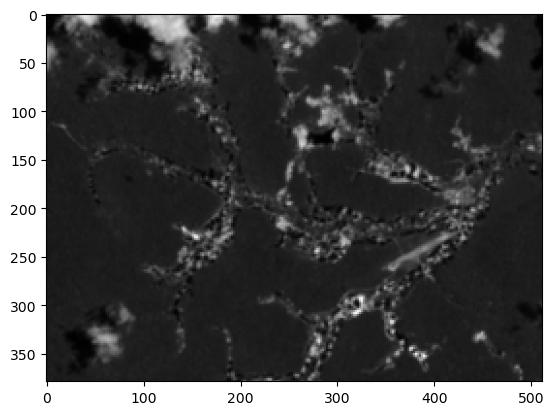

In [5]:
opn_b12_reprojected = reproject_image(band_12_example_file,
                                     test_file)
print ('Band 2 Data Dimensions:')
print (opn_v1.RasterYSize, opn_v1.RasterXSize)

print ('Reprojected Band 12 Data Dimensions:')
print (opn_b12_reprojected.RasterYSize, opn_b12_reprojected.RasterXSize)

# notice everything lines up as the same dimensions now!

# lets take a quick look at how this B12 data looks
arr_b12_reprojected = opn_b12_reprojected.ReadAsArray()
plt.imshow(arr_b12_reprojected[0])

You can also pass a shapefile to reproject_image, and the function will reproject the image AND use the shapefile to subset the data.

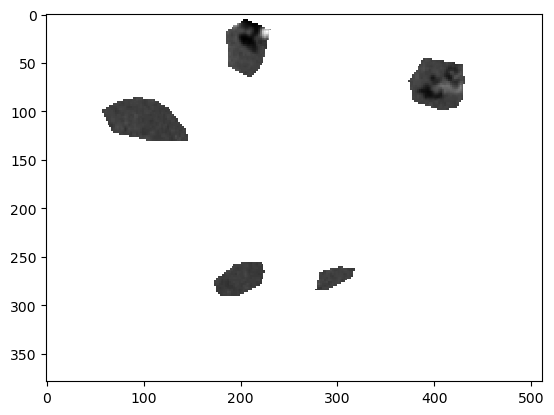

In [6]:
opn_b12_reprojected_subset = reproject_image(band_12_example_file,
                                             test_file,
                                             clip_shapefile=test_shapefile)

# lets take a quick look at how this B12 data looks
arr_b12_reprojected_subset = opn_b12_reprojected_subset.ReadAsArray()

# set the values outside the shapefiles as np.nan
arr_b12_reprojected_subset = arr_b12_reprojected_subset.astype(np.float32)
arr_b12_reprojected_subset[arr_b12_reprojected_subset == no_dataval] = np.nan
plt.imshow(arr_b12_reprojected_subset[0])

# the output of this is where you can see allot of data has been set 
# to np.nan (not-a-number), which means it falls outside our boundaries
# of the geometries in the shapefile.

To make our job easier, we will use a function to open up the data, and create a layer stack for Sentinel 1, as well as another function to create a layer stack from Sentinel 2 data as well. All the data will be opened with 'reproject_image' so all the data has the same shape and dimensions. We will use 'test_file' to reproject all the data, so everything has the same shape and dimensions as a Sentinel 2 B2 file.

In [7]:
from day3_helpers import compile_sentinel_1_stacks

In [8]:
# List all the Sentinel 1 data we want to open        
s1_bands = ['VH_DESCENDING', 'VV_DESCENDING']
year = '2022'
s1_data = compile_sentinel_1_stacks('/data/un_suriname_demo/datacube/',
                                       s1_bands, '2022', test_file,
                                       shapefile = test_shapefile)

(31, 379, 512)


Text(0, 0.5, '$VH\\ Backscatter\\ (\\sigma)$')

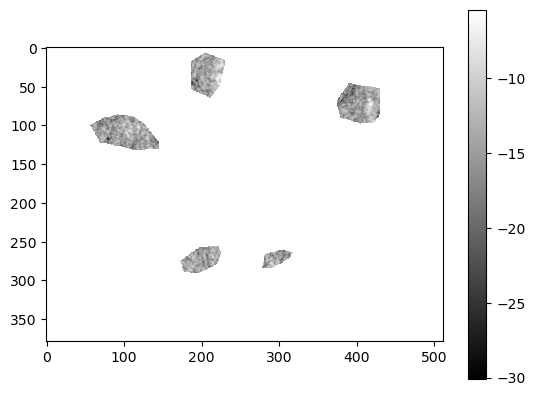

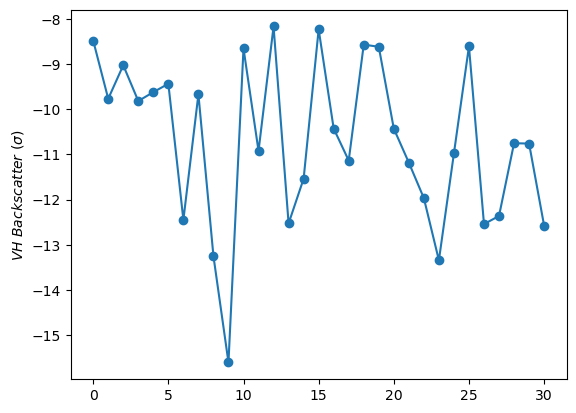

In [9]:
# now we have a 3D layer stack for each of the s1_bands
print (s1_data['VH_DESCENDING'].shape)
plt.imshow(s1_data['VH_DESCENDING'][0])
plt.colorbar()

# plot the values in time for one of the pixels
plt.figure()
plt.plot(s1_data['VH_DESCENDING'][:,100,100], marker='o')
plt.ylabel('$VH\ Backscatter\ (\sigma)$')

We will use another function to compile the S2 data layer stack in a very similar way to the Sentinel 1 function

In [10]:
from day3_helpers import compile_sentinel_2_stacks

In [11]:
s2_bands = ['B2','B3','B4','B5','B6','B7','B8',
           'B8A','B11','B12']

# for diplay purposes, we wont open with a shapefile,
# just so we can see the whole scene
s2_data = compile_sentinel_2_stacks('/data/un_suriname_demo/datacube/',
                                   s2_bands, year, test_file )

Next, we need a function that can find the cloud mask. This is a boolean, where True means the data point is clouded.

In [12]:
from day3_helpers import find_sentinel_2_cloudmask

In [13]:
# implement this function and adjust critical_cloud_threshold
# to your needs. Remember, a lower value means more values are
# masked out.
s2_cloudmask = find_sentinel_2_cloudmask(s2_data, critical_cloud_threshold=500)

In [14]:
# use this cloudmask to mask each of the layer stacks inside
# the variable 's2_data'
for band in s2_bands:
    s2_data[band][s2_cloudmask] = np.nan

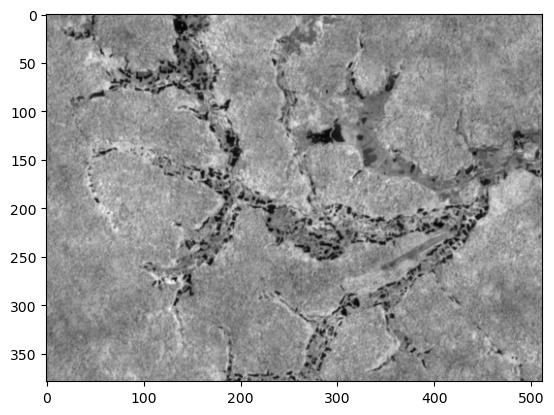

In [19]:
plt.imshow(np.nanmean(s2_data['B8'], axis=0))

Now we have a clean dataset that has had cloud masking applied, we can derive some spectral indexes. This will be done in a function where you are encouraged to find your own spectral indexes and write them into the function. The format of the function will take in the cloud masked dictionary 's2_data' and add new keys to the dictionary with the spectral index data inside the new keys.

In [15]:
def generate_spectral_indexes(reflectance_dict):
    
    # When finding spectral indexes to use in landcover classification
    # it is always best to pick indexes that target a variety of
    # landcovers. In this example, we will derive a vegetation index,
    # a water index and a soil index, where each index will highlight
    # different landcovers.
    
    # Below are some examples, but use the following link to
    # derive as many indexes as possible for Sentinel 2
    # https://www.indexdatabase.de/db/s-single.php?id=96
    
    # there is a more complex but complete list of indexes
    # found here:
    # https://github.com/awesome-spectral-indices/spyndex/blob/main/spyndex/data/spectral-indices-dict.json
    
    # for the vegetation, we will use NDVI 
    ndvi = (reflectance_dict['B8'] - reflectance_dict['B4']) / \
           (reflectance_dict['B8'] + reflectance_dict['B4'])
    
    # for water, we will use the NDWI, where the details can be
    # found here:
    # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
    ndwi = (reflectance_dict['B3'] - reflectance_dict['B8']) / \
           (reflectance_dict['B3'] + reflectance_dict['B8'])
    
    # and for the soil, we will use the Bare Soil Index
    # which is listed in this article (along with other helpful indexes):
    # https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/
    bsi = ((reflectance_dict['B11'] + reflectance_dict['B4']) - \
           (reflectance_dict['B8'] + reflectance_dict['B2'])) / \
          ((reflectance_dict['B11'] + reflectance_dict['B4']) + \
           (reflectance_dict['B8'] + reflectance_dict['B2']))
    
    # now we have calculated all the indexes, lets add them to our 
    # dictionary, so we can use them later. If you have calcualted
    # your own indexes, remeber to add them to the dictionary here
    # under an appropriate key
    
    reflectance_dict['NDVI'] = ndvi
    reflectance_dict['NDWI'] = ndwi
    reflectance_dict['BSI'] = bsi
    
generate_spectral_indexes(s2_data)

Finally, we need a function that can generate 2D composites from a variety of 3D datasets, for use in our classification. These 
operations will carry out mathmatical operations along the time axis of the data and return a 2d array.

In the function below, there are few functions included, but you are encouraged to find other operations to use in this link:
https://numpy.org/doc/stable/reference/routines.statistics.html

The function works by looping throught the keys of a dictionary and performing the operations on the 3D arrays iteratively and 
then saving the data to a new dictionary with new keys.

In [16]:
def derive_composites(reflectance_data):
    
    composites = {}
    
    # loop throguh each of the keys of the input dictionary
    for band in reflectance_data:
        
        # find the average composite
        average_composite = np.nanmean(reflectance_data[band], axis = 0)
        # add this new composite to the dictionary
        composites['%s_mean'%band] = average_composite
        
        # find the maximum composite
        maximum_composite = np.nanmax(reflectance_data[band], axis = 0)
        composites['%s_maximum'%band] = maximum_composite
        
        # find the minimum composite
        minimum_composite = np.nanmin(reflectance_data[band], axis = 0)
        composites['%s_minimum'%band] = minimum_composite
        
        # here is where you want to derive you own statistics
        # try using:
        # https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html
        # or this operations
        # https://numpy.org/doc/stable/reference/generated/numpy.nanstd.html
    
    return composites

composites = derive_composites(s2_data)

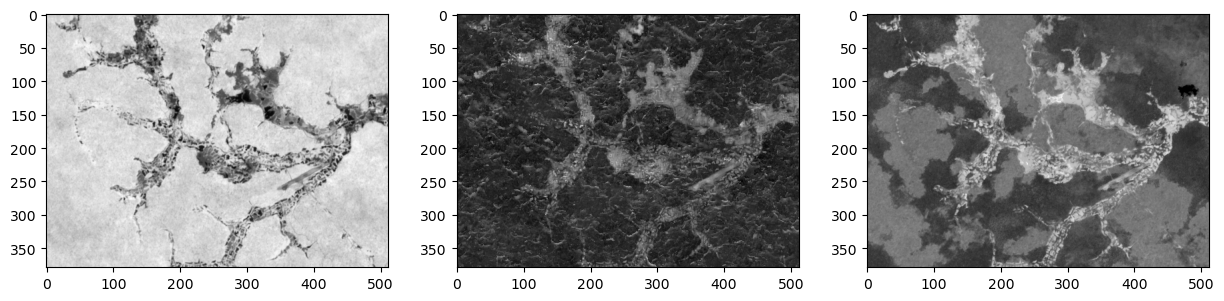

In [17]:
# lets have a look at some of them
fig,axs = plt.subplots(1,3,figsize=(15,4))
axs[0].imshow(composites['NDVI_mean'])
axs[1].imshow(composites['BSI_maximum'])
axs[2].imshow(composites['NDWI_minimum'])

## Section 2 - Generating the Feature Space
In this section, we will use two shapefiles to generate various features for 'Forested landscape' and 'Exposed Mining Landcover'. This will use the tools above, where we will open Sentinel 1 and Sentinel 2,but we will reproject the data to the same file and spatial arrangement in order that everything is alligns spatially. The Sentinel 2 will then be cloudmasked, the spectral indexes will be calculated, and we then composites will then be made from both Sentine 1 and Sentinel 2.

In [18]:
# critical variables for opening the data
shapefile_forest = '/media/DataShare/Alex/un_surinam/forest.shp'
shapefile_mining = '/media/DataShare/Alex/un_surinam/mining.shp'

file_to_project_onto = '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-09.tif'
cloudmask_threshold = 1000
year = '2022'

In [19]:
# open the data for the forested polygons
s1_data_forest = compile_sentinel_1_stacks('/data/un_suriname_demo/datacube/',
                                       s1_bands, year, file_to_project_onto,
                                       shapefile = shapefile_forest)
s2_data_forest = compile_sentinel_2_stacks('/data/un_suriname_demo/datacube/',
                                       s2_bands, year, file_to_project_onto,
                                       shapefile = shapefile_forest)

cloudmask_forest = find_sentinel_2_cloudmask(s2_data_forest, 
                                             critical_cloud_threshold = cloudmask_threshold)

for band in s2_bands:
    s2_data_forest[band][cloudmask_forest] = np.nan
    
generate_spectral_indexes(s2_data_forest)

s1_composites_forest = derive_composites(s1_data_forest)
s2_composites_forest = derive_composites(s2_data_forest)

In [20]:
# open the data for the mining polygons
s1_data_mining = compile_sentinel_1_stacks('/data/un_suriname_demo/datacube/',
                                       s1_bands, year, file_to_project_onto,
                                       shapefile = shapefile_mining)
s2_data_mining = compile_sentinel_2_stacks('/data/un_suriname_demo/datacube/',
                                       s2_bands, year, file_to_project_onto,
                                       shapefile = shapefile_mining)

cloudmask_mining = find_sentinel_2_cloudmask(s2_data_mining, 
                                             critical_cloud_threshold = cloudmask_threshold)

for band in s2_bands:
    s2_data_mining[band][cloudmask_mining] = np.nan
    
generate_spectral_indexes(s2_data_mining)

s1_composites_mining = derive_composites(s1_data_mining)
s2_composites_mining = derive_composites(s2_data_mining)

Text(0.5, 1.0, 'BSI Maximum Mining Landcover')

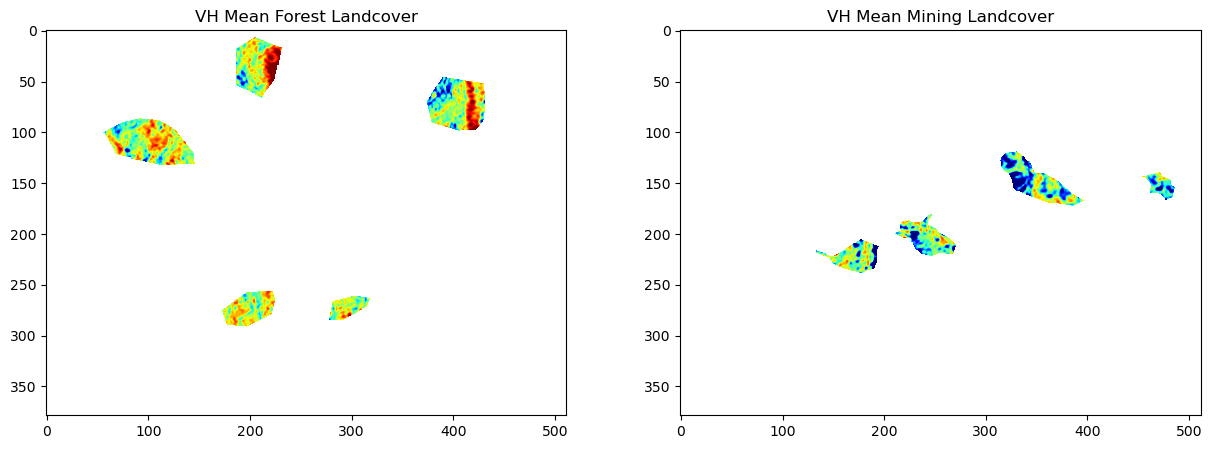

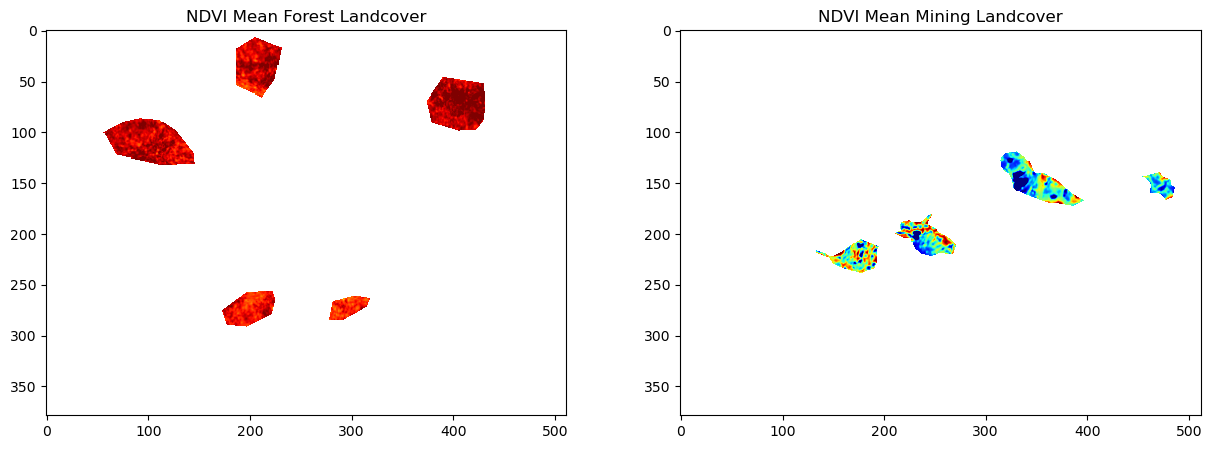

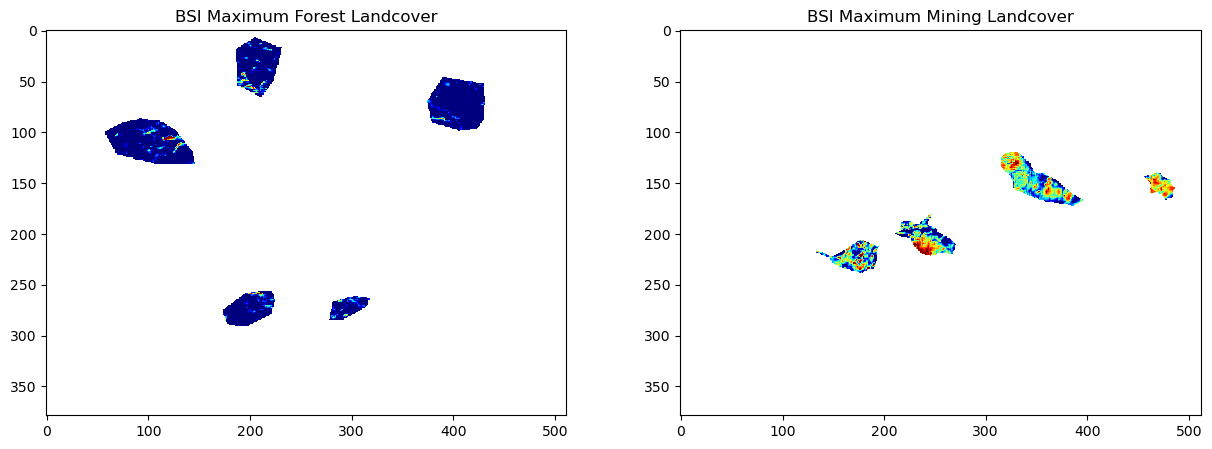

In [21]:
# lets look at the data so we can see the different between some of the composites

# Sentinel 1 VH Mean composites
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(s1_composites_forest['VH_DESCENDING_mean'],
              vmin=-20,vmax=-10,cmap='jet')
axs[1].imshow(s1_composites_mining['VH_DESCENDING_mean'],
              vmin=-20,vmax=-10,cmap='jet')
axs[0].set_title('VH Mean Forest Landcover')
axs[1].set_title('VH Mean Mining Landcover')

# Sentinel 2 Mean Composite 
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(s2_composites_forest['NDVI_mean'],
              vmin=0,vmax=0.5,cmap='jet')
axs[1].imshow(s2_composites_mining['NDVI_mean'],
              vmin=0,vmax=0.5,cmap='jet')
axs[0].set_title('NDVI Mean Forest Landcover')
axs[1].set_title('NDVI Mean Mining Landcover')

# Sentinel 2 BSI Max
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(s2_composites_forest['BSI_maximum'],
              vmin=0,vmax=0.2,cmap='jet')
axs[1].imshow(s2_composites_mining['BSI_maximum'],
              vmin=0,vmax=0.2,cmap='jet')
axs[0].set_title('BSI Maximum Forest Landcover')
axs[1].set_title('BSI Maximum Mining Landcover')

In [23]:
# merge the Sentinel 1 and Sentinel 2 composites into single dictionaries
# td stands for training data
td_forest = {** s1_composites_forest, ** s2_composites_forest}
td_mining = {** s1_composites_mining, ** s2_composites_mining}

# for each dataset, we need the indicies of where the data is real, 
# so not 'np.nans'. This will be unique for mining / landcover.

# pick any composite to use
forest_data_index = np.where(np.isnan(td_forest['B2_mean']) == False) 
mining_data_index = np.where(np.isnan(td_mining['B2_mean']) == False) 

In [24]:
# how does this 'np.where' command work?
# firstly, there is there is an 'np.isnan' which finds which values
# in the 2d array which are nan or not
are_nan = np.isnan(td_forest['B2_mean'])
# a value of True means the value is naned out

# then the second aspect is np.where, which queries this 2D True/False
# array and finds the indexes of the data where there are False
print (np.where(are_nan == False))

(array([  6,   6,   6, ..., 291, 292, 292]), array([204, 205, 206, ..., 199, 196, 197]))


We can test this by getting the first datapoint which is not nan in the forest dataset. In the pronted statement above, we can see the forst index is [6,204]. This means index [6,204] is a valid forested pixel.

In [26]:
print (td_forest['B2_mean'][6,204])

1635.7333


In [27]:
# we now need to 'flatten' the arrays in each 'td' variable, 
# from a 2D array to a 1D array of only containing real values

# create new dictionaries for the new flattened data
td_forest_f = {}
for i in td_forest:
    td_forest_f[i] = td_forest[i][forest_data_index]
    
td_mining_f = {}
for i in td_mining:
    td_mining_f[i] = td_mining[i][mining_data_index]

In [29]:
# notice the difference in shapes and sizes between the two
# datasets
print (td_forest['NDVI_mean'].shape)
print (td_forest_f['NDVI_mean'].shape)

(379, 512)
(9703,)


In [46]:
# now we have everything to get generate the feature space!

# 'xa' is a variable used to name a feature space in 
# this notebook
xa_forest = np.array(list(td_forest_f.values()))
xa_mining = np.array(list(td_mining_f.values()))

# this command works by using the functionality of 
# a dictionary, which returns the values within
# the dictionary with the '.values()' command.
# We then cast this to the python List, then into 
# a numpy array so we can manipulate it easier

# we can get the names of each feature by using the 
# keys of the dictionary, recast to numpy arrays
feature_names = np.array(list(td_forest_f.keys()))

In [47]:
# we need the 'xa' valiables to be transposed for 
# the format that the ML algorthms need. We can
# do this with the method '.T' on the numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html
xa_forest = xa_forest.T
xa_mining = xa_mining.T

Lets look at this feature space now it is generated:

In [48]:
print ('Number of Features')
print (xa_mining.shape[1])
print (' ')
print ('Feature names:')
print (feature_names)
print (' ')
print ('Number of Mining Samples: ',xa_mining.shape[0])
print ('Number of Forested Samples: ',xa_forest.shape[0])

Number of Features
45
 
Feature names:
['VH_DESCENDING_mean' 'VH_DESCENDING_maximum' 'VH_DESCENDING_minimum'
 'VV_DESCENDING_mean' 'VV_DESCENDING_maximum' 'VV_DESCENDING_minimum'
 'B2_mean' 'B2_maximum' 'B2_minimum' 'B3_mean' 'B3_maximum' 'B3_minimum'
 'B4_mean' 'B4_maximum' 'B4_minimum' 'B5_mean' 'B5_maximum' 'B5_minimum'
 'B6_mean' 'B6_maximum' 'B6_minimum' 'B7_mean' 'B7_maximum' 'B7_minimum'
 'B8_mean' 'B8_maximum' 'B8_minimum' 'B8A_mean' 'B8A_maximum'
 'B8A_minimum' 'B11_mean' 'B11_maximum' 'B11_minimum' 'B12_mean'
 'B12_maximum' 'B12_minimum' 'NDVI_mean' 'NDVI_maximum' 'NDVI_minimum'
 'NDWI_mean' 'NDWI_maximum' 'NDWI_minimum' 'BSI_mean' 'BSI_maximum'
 'BSI_minimum']
 
Number of Mining Samples:  5064
Number of Forested Samples:  9703


Finally, to complete generating the feature space, we need to create a set of labels, to act as the target variable, then  concatenate everything together so we have a complete dataset.

We will label pixels that are mining as '1' and pixels that are forested as 0. The labels are repeated values that are the same length as each dataset for each landcover.

In [49]:
mining_label_val = 1
forest_label_val = 0

mining_labels = np.repeat(mining_label_val, len(xa_mining))
forest_labels = np.repeat(forest_label_val, len(xa_forest))

# 'ya' is a good variable name for the target_variable
ya = np.concatenate([mining_labels, forest_labels])

# we will create a variable 'xa' which contains both the mining
# and forest feature spaces
xa = np.concatenate([xa_mining, xa_forest])

print (xa.shape, ya.shape)

(14767, 45) (14767,)


In [50]:
# we also need to eliminate samples with nans in
non_nan_idx = np.all(np.isfinite(xa), axis=1)
xa = xa[non_nan_idx]
ya = ya[non_nan_idx]

## Section 2 - Displaying Key Features
This section is going to look at how to display the relationship between the target variable and the different features in both the mining and forested landcover types. We will firstly look at a gaussian KDE, which is a way of displaying the distribution of a dataset. The datasets can be any size, so it is very easy to show the distriubution of unbalanced datasets.

A KDE is simple to use a very effective. It calcualtes the probability of new value being drawn from the training population. 

We just have to generate a new KDE function using scipy.stats, then we call this function when we need to. Lets display the KDE of the BSI_mean values, which in the feature space is 42. Note, if you have added more spectral indexes or more operations to the 'derive_composites' function, then 42 will not correspond to 'BSI_mean'

In [51]:
# if you need to see which features correspond with each index 
# then uncomment the below line and run the cell

# ['%s_%s'%(n,i) for n,i in enumerate(feature_names)]

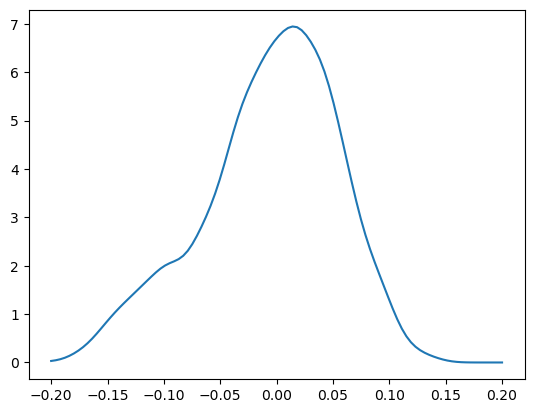

In [52]:
feature_num = 42

# next call the 1D distribution of the feature for 1 landcover 
# class. Access all samples with the ':' symbol, then feature
# number 42
distribution_mining = xa_mining[:,feature_num]

# we can only display data that has no nans in it, so find
# where values are not nans
real_values = np.where(np.isfinite(distribution_mining) == True) 

# instantate a new KDE
kde_mining = scipy.stats.gaussian_kde(distribution_mining[real_values])

# generate a sample of values to test
# BSI can vary between -0.2 and 0.2 in or test case
test_bsi_vals = np.linspace(-0.2,0.2,100)
# linspace documentation here:
# https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

# find what the probability of each test BSI value is within the
# mining landcover type
kde_estimate_mining = kde_mining(test_bsi_vals)

# plot it
plt.plot(test_bsi_vals, kde_estimate_mining)

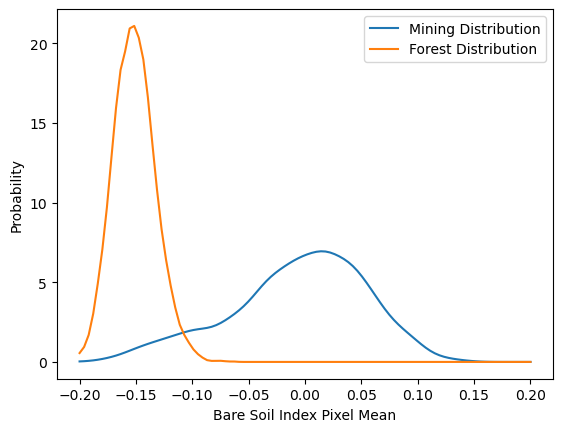

In [53]:
# do this all again, but looking at the forest KDE and see how 
# they differ
distribution_forest = xa_forest[:,feature_num]
real_values = np.where(np.isfinite(distribution_forest) == True) 
kde_forest = scipy.stats.gaussian_kde(distribution_forest[real_values])
kde_estimate_forest = kde_forest(test_bsi_vals)

plt.plot(test_bsi_vals, kde_estimate_mining, 
        label='Mining Distribution')

plt.plot(test_bsi_vals, kde_estimate_forest, 
        label='Forest Distribution')

plt.xlabel('Bare Soil Index Pixel Mean')
plt.ylabel('Probability')
plt.legend()

# from this we can see that if a pixel has a BSI_mean value
# of -0.15, then it is very likely to be in the 'Forest' 
# distribution

#### Test Your Understanding:
Display the KDEs of the mining and landcover class for a few different features and find ones which have very good seperability between classes. This is where the peaks in probability for the mining/fortest KDEs dont overlap much.

In [54]:
# test you understanding kernal


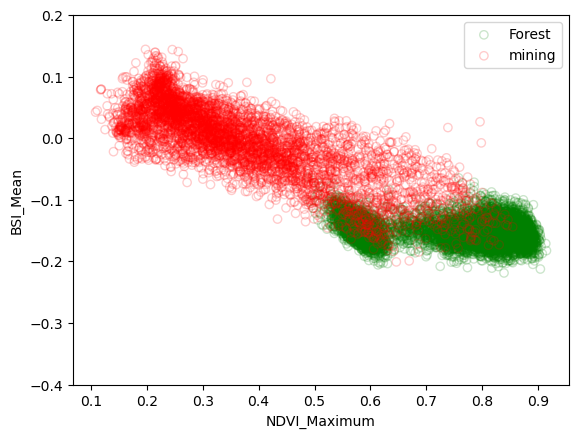

In [56]:
# Next is where we will display how the correlations between features
# relates to the target variable.

# all this takes is scattering the columns in 'xa' against one another 
# and colouring the points based off their landcover class

# in this example we will scatter feature 37 (NDVI_maximum)
# against feature 42 (BSI_Mean)

plt.scatter(xa_forest[:,37],xa_forest[:,42],edgecolor='g',
            alpha=0.2,label='Forest',facecolor='none')

plt.scatter(xa_mining[:,37],xa_mining[:,42],edgecolor='r',
            alpha=0.2,label='mining',facecolor='none')

plt.ylim(-0.4,0.2)
plt.xlabel('NDVI_Maximum')
plt.ylabel('BSI_Mean')
plt.legend()

This graph shows that when NDVI_maximum is low and BSI_mean is high - the pixel is very likely to belong to the 'mining' landcover.

## Section 3 - Training ML Classifiers
This section will go over how we will call and train different classifiers, which vary in complexity and sophistication. We will learn how to randomly partition a dataset into a trainging/validation 70/30 split, how to balance the training dataset and how to call different ML models with different structures

In [57]:
# First, we need to split 'xa' into a 70% training set and 30% validation set.

# setup an array of all possible samples for the training
possible_indexes = np.arange(len(xa))

# find how many samples are 70% of the dataset 
num_in_training = int(len(xa) * 0.7)

# randomly sample 70% of these. 'np.random.choise. will randomly pick 
# a sample size from the array it is given.
training_indexes = np.random.choice(possible_indexes,
                                   num_in_training,
                                   replace=False)

# find the validation samples if they are not in the 
# training_indexes. This uses list comprehension where
# details can be found here:
# https://www.w3schools.com/python/python_lists_comprehension.asp
validation_indexes = np.array([i for i in possible_indexes if 
                                 i not in training_indexes])

In [58]:
# now we have the indexes for the training and validation,
# we need to partition 'xa' and 'ya' in these sections.

# training datasets:
xt = xa[training_indexes]
yt = ya[training_indexes]

# validation datasets:
xv = xa[validation_indexes]
yv = ya[validation_indexes]

# we will train the datasets on the training datasets, then
# test the algorthms on the validation datasets. 

(array([6646.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3438.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

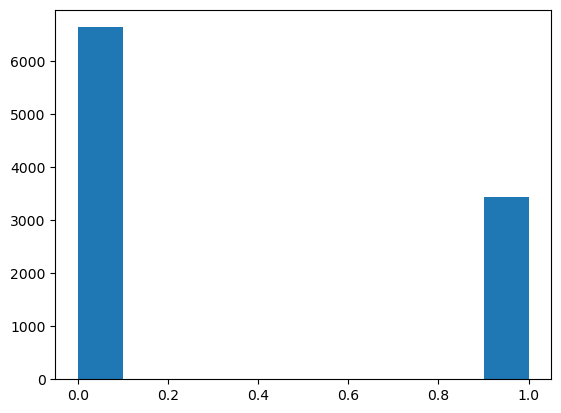

In [59]:
# notice, that there are more 0s than 1s in the training 
# dataset, which means we have an unbalanced dataset
plt.hist(yt)

(array([3509.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3509.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

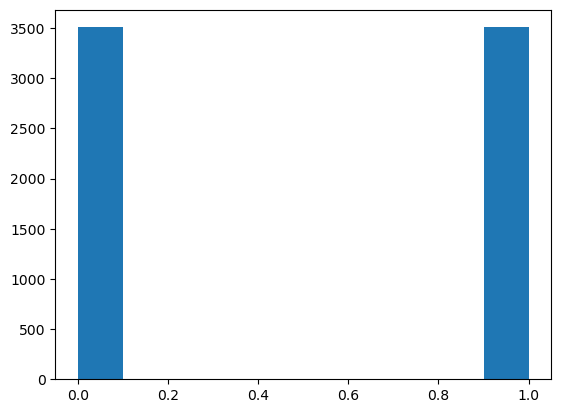

In [40]:
# to randomly undersample, we basically take a random subsample of 
# the 'forest' training point, so there are equal numbers of 0 and
# 1 in the training dataset

forest_idxs = np.where(yt == 0)[0]
mining_idxs = np.where(yt == 1)[0]

forest_idxs_undersampled = np.random.choice(forest_idxs,
                                            len(mining_idxs),
                                            replace=False)

all_undersampled_idxs = np.concatenate([forest_idxs_undersampled,
                                       mining_idxs])

# set xt and xt to the undersampled idxs
xt = xt[all_undersampled_idxs]
yt = yt[all_undersampled_idxs]

# notice now with the histogram how both bars have the same height
plt.hist(yt)

Everything is now setup for training the classifiers. We will use three different models here:

Model 1 - single decision tree<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier<br>
This is a single decision tree that trains by partitioning the dataset into iteratively more pure and accurate clusters. 

Model 2 - Random Forest Classifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br>
Very similar as above by there multiple trees, that are each trained on a random sample of data and features, which makes the classifier more reliable. 

Model 3 - XGBoost Classifier<br>
https://xgboost.readthedocs.io/en/stable/python/python_api.html<br>
Again, this model is made from an ensemble of decision trees but the model optimizes its own hyperparameters to avoid overfitting

In [61]:
import sklearn.tree
import sklearn.ensemble
import xgboost

In [64]:
# we will set some parameters to limit the classifiers
# and prevent them 'growing too big' or get overfitted
classifier_max_depth = 5
classifier_max_leaf_nodes = 10

# we will train the first model with the following commands
ml_model_v1 = sklearn.tree.DecisionTreeClassifier(max_depth=classifier_max_depth, 
                                                 max_leaf_nodes=classifier_max_leaf_nodes)
ml_model_v1.fit(xt,yt)
# the model is now trained and able to be applied to data.
# lets see what it would predict for the first training point
print ('ML model 1 predicts class:')
print (ml_model_v1.predict(xt[:1]))
print ('Actual class is:')
print (yt[:1])

ML model 1 predicts class:
[0]
Actual class is:
[0]


Lets test how the model did with the whole validation data first, we need to find what the model predicts for all the validation data points

In [66]:
ml_model_v1_prediction = ml_model_v1.predict(xv)

# we can get a full readout of the performance
# for a full explanation on all the stats, please see:
# https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
print (sklearn.metrics.classification_report(ml_model_v1_prediction,yv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2847
           1       0.99      0.99      0.99      1476

    accuracy                           0.99      4323
   macro avg       0.99      0.99      0.99      4323
weighted avg       0.99      0.99      0.99      4323



In [67]:
# you can also get the accuracy score like this
ml_model_v1.score(xv, yv)

0.9949109414758269

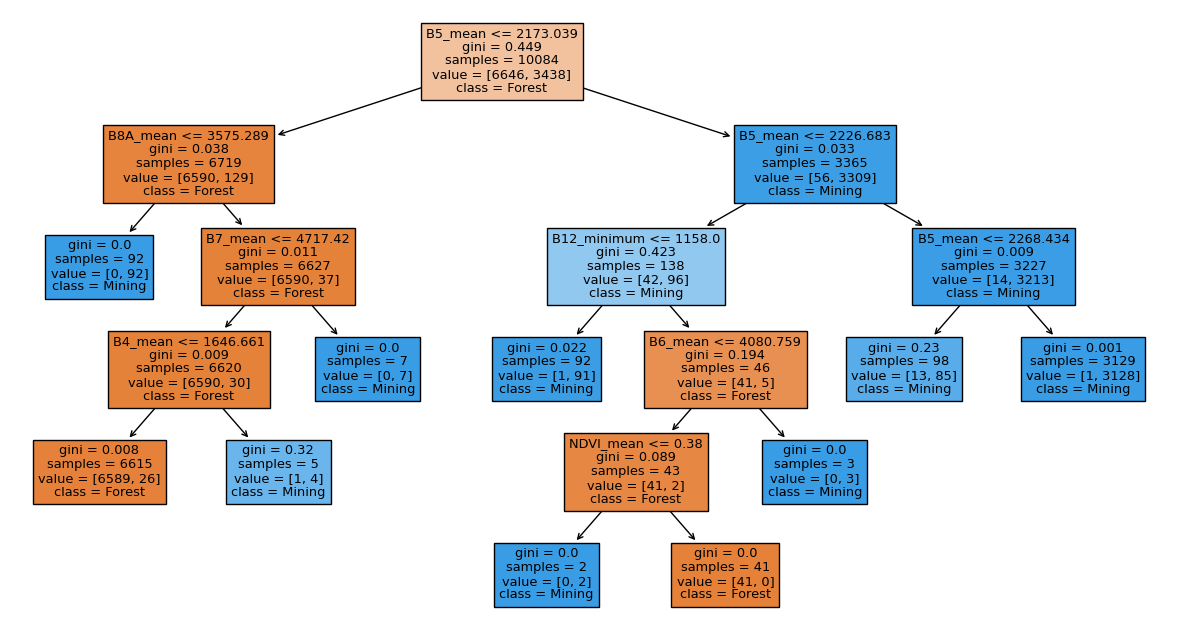

In [68]:
# we can also visualize the decision tree with the sklearn 
# plotting function:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree
plt.figure(figsize=(15,8))
_ = sklearn.tree.plot_tree(ml_model_v1, feature_names=feature_names, 
                          filled=True,class_names=['Forest', 'Mining'])

Lets train our second model which is the random forest classifier, which uses the 'sklearn.ensemble' class as there is an ensemble of decison trees created

In [69]:
ml_model_v2 = sklearn.ensemble.RandomForestClassifier(max_depth=classifier_max_depth,
                                                     max_leaf_nodes=classifier_max_leaf_nodes,)
ml_model_v2.fit(xt,yt)

RandomForestClassifier(max_depth=5, max_leaf_nodes=10)

In [70]:
# lets find how this model scores with the validation data
ml_model_v2_prediction = ml_model_v2.predict(xv)
print (sklearn.metrics.classification_report(ml_model_v2_prediction,yv))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2854
           1       0.99      1.00      0.99      1469

    accuracy                           1.00      4323
   macro avg       0.99      1.00      1.00      4323
weighted avg       1.00      1.00      1.00      4323



In [71]:
# lets compare the scores of the models
print ('Model 1 Score')
print (ml_model_v1.score(xv,yv))
print ('Model 2 Score')
print (ml_model_v2.score(xv,yv))

Model 1 Score
0.9949109414758269
Model 2 Score
0.9956049040018505


We can also look at the feature importances, which is how usefull the model thinks each feature is.

Text(0, 0.5, 'Relative Importance')

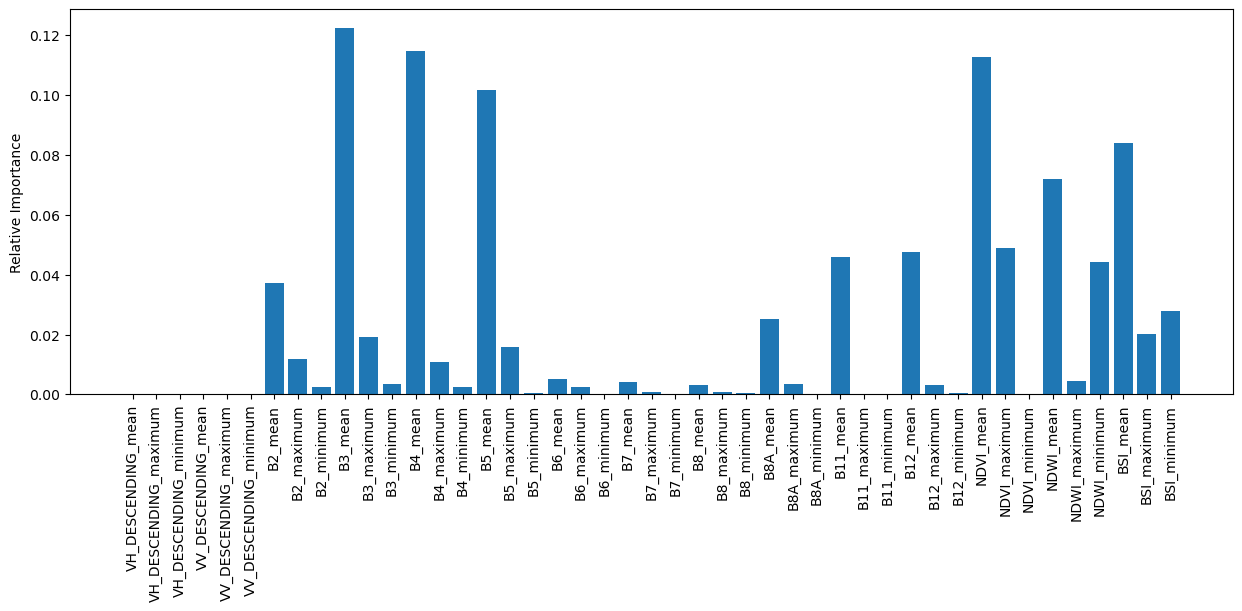

In [72]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(0,len(feature_names)),
        ml_model_v2.feature_importances_)
_ = plt.xticks(np.arange(0,len(feature_names)),
          feature_names,rotation=90)
plt.ylabel('Relative Importance')

# This higher the bar, the more the model values the feature
# in discriminating between Mining and forest landcover

We can finally train our 3rd model. Notice for this example we dont need to add the parameters to limit the tree growth, as XGBoost will optimize them for us to get the best model arrangment.

In [73]:
ml_model_v3 = xgboost.XGBClassifier()
ml_model_v3.fit(xt,yt)

[10:19:17] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
# test Model 3 out
ml_model_v3_prediction = ml_model_v3.predict(xv)
print (sklearn.metrics.classification_report(ml_model_v3_prediction,yv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       1.00      1.00      1.00      1480

    accuracy                           1.00      4323
   macro avg       1.00      1.00      1.00      4323
weighted avg       1.00      1.00      1.00      4323



## Section 4 - Model Implementation
Now all the models are trained, we now have to apply them to the whole scene and not just on the training data. This means we have to load the whole datasaset, mask the clouds, generate the spectral indexes and fianlly arange the data ready for the ML 

In [75]:
# open the data, but dont supply and shapefile so that the 
# full scene is opened.

s1_data_complete_scene = compile_sentinel_1_stacks('/data/un_suriname_demo/datacube/',
                                       s1_bands, '2022', file_to_project_onto)

s2_data_complete_scene = compile_sentinel_2_stacks('/data/un_suriname_demo/datacube/',
                                       s2_bands, year, file_to_project_onto)

cloudmask_complete_scene = find_sentinel_2_cloudmask(s2_data_complete_scene, 
                                             critical_cloud_threshold = cloudmask_threshold)

for band in s2_bands:
    s2_data_complete_scene[band][cloudmask_complete_scene] = np.nan
    
generate_spectral_indexes(s2_data_complete_scene)

s1_composites_complete_scene = derive_composites(s1_data_complete_scene)
s2_composites_complete_scene = derive_composites(s2_data_complete_scene)

In [76]:
data_complete_scene = {** s1_composites_complete_scene, ** s2_composites_complete_scene}
xa_complete_scene = np.array(list(data_complete_scene.values()))

Everything is now loaded up in the variable 'xa_complete_scene'. To apply the ML models, we need to manipulate the array into 
[sample][feature] format for the models to use. As we will do this a few times for each model, we will use the following function to apply the models.

In [77]:
def apply_ml_classifier(in_xa, model_to_use):
    
    # flatten the last two dimensions, which are latitude 
    # and logitude. For more information see:
    # https://www.w3schools.com/python/numpy/numpy_array_reshape.asp    
    xa_flattened = in_xa.reshape([in_xa.shape[0],
                                 in_xa.shape[1] * in_xa.shape[2]]).T
    
    
    # use the model to predict the binary classification
    prediction_binary = model_to_use.predict(xa_flattened)
    
    # also, use the predict_proba method to find the likihood 
    # of classification of class 0 and 1
    prediction_proba = model_to_use.predict_proba(xa_flattened)
    
    # the predictions are in long 1D arrays and not shaped
    # in 2d images which we can display. We reshape the outputs
    # into 2d arrays, using the information of shape in the 
    # incoming arrays
    output_2d_shape = in_xa[0].shape
    prediction_binary_2d = prediction_binary.reshape(output_2d_shape)
    prediction_proba_forest = prediction_proba[:,0].reshape(output_2d_shape)
    prediction_proba_mining = prediction_proba[:,1].reshape(output_2d_shape)    
    
    return prediction_binary_2d, prediction_proba_forest, prediction_proba_mining

# lets test this on Model 1
output_v1, output_v1_fp, output_v1_mp = apply_ml_classifier(xa_complete_scene, ml_model_v1)

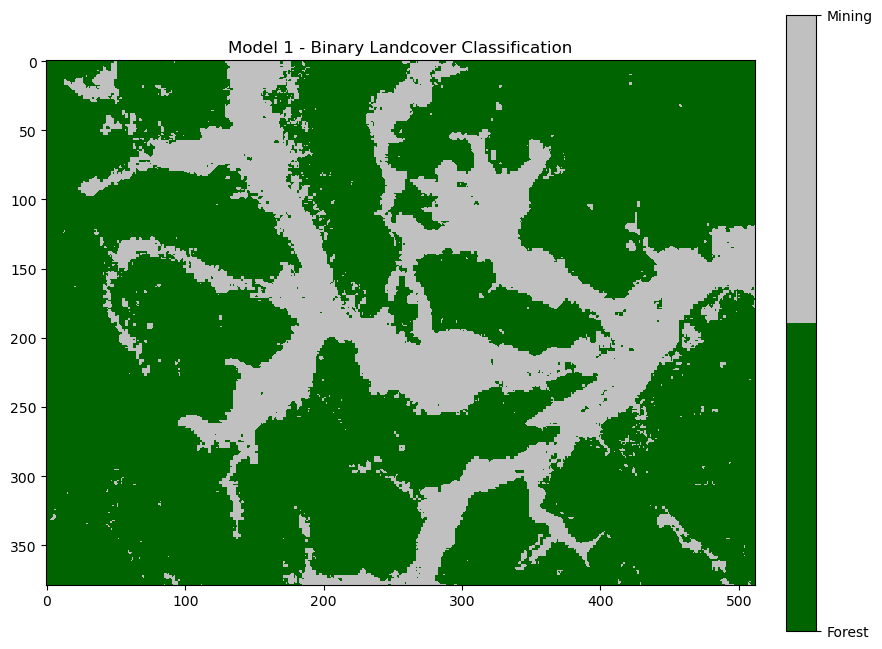

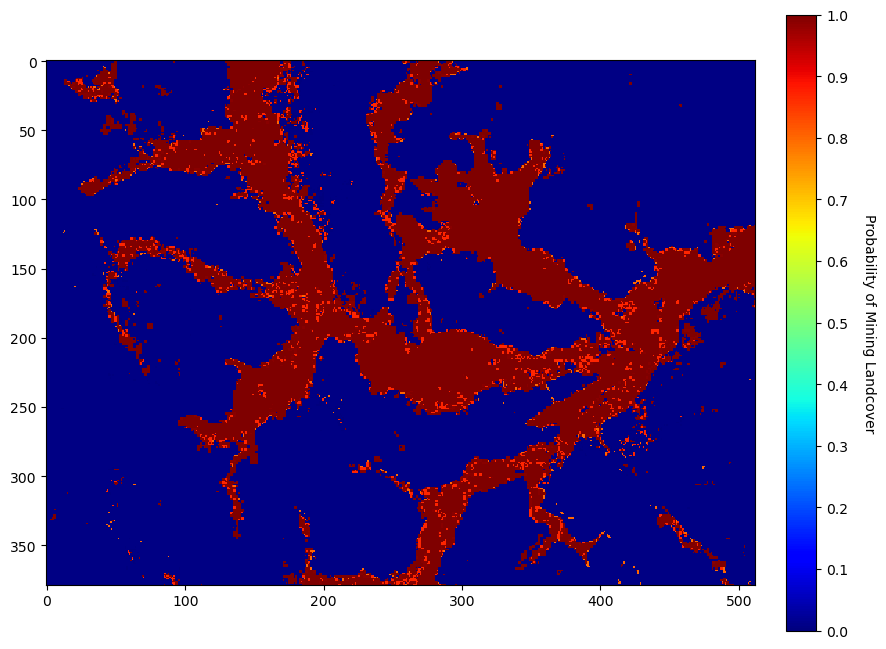

In [83]:
# we will setup a colormap to show the outputs
# please see the following colors to create your
# own colorscheme:
# https://matplotlib.org/stable/gallery/color/named_colors.html
cmap = ListedColormap(['darkgreen','silver'])

# plot the binary results
plt.figure(figsize=(10,8))
plt.imshow(output_v1,cmap=cmap)
plt.title('Model 1 - Binary Landcover Classification')
bar = plt.colorbar(fraction=0.046, pad=0.04)
bar.set_ticks([0,1])
bar.set_ticklabels(['Forest','Mining'])

# plot the liklihood of mining
plt.figure(figsize=(10,8))
plt.imshow(output_v1_mp,cmap='jet',interpolation='none')
bar = plt.colorbar(fraction=0.046, pad=0.04)
bar.set_label('Probability of Mining Landcover',
              rotation=270, labelpad=20)
bar.set_ticks(np.arange(0,1.1,0.1))

In [84]:
# import some display helpers
from day3_helpers import display_esri_2022_basemap, overlay_output_on_esri_2022_basemap

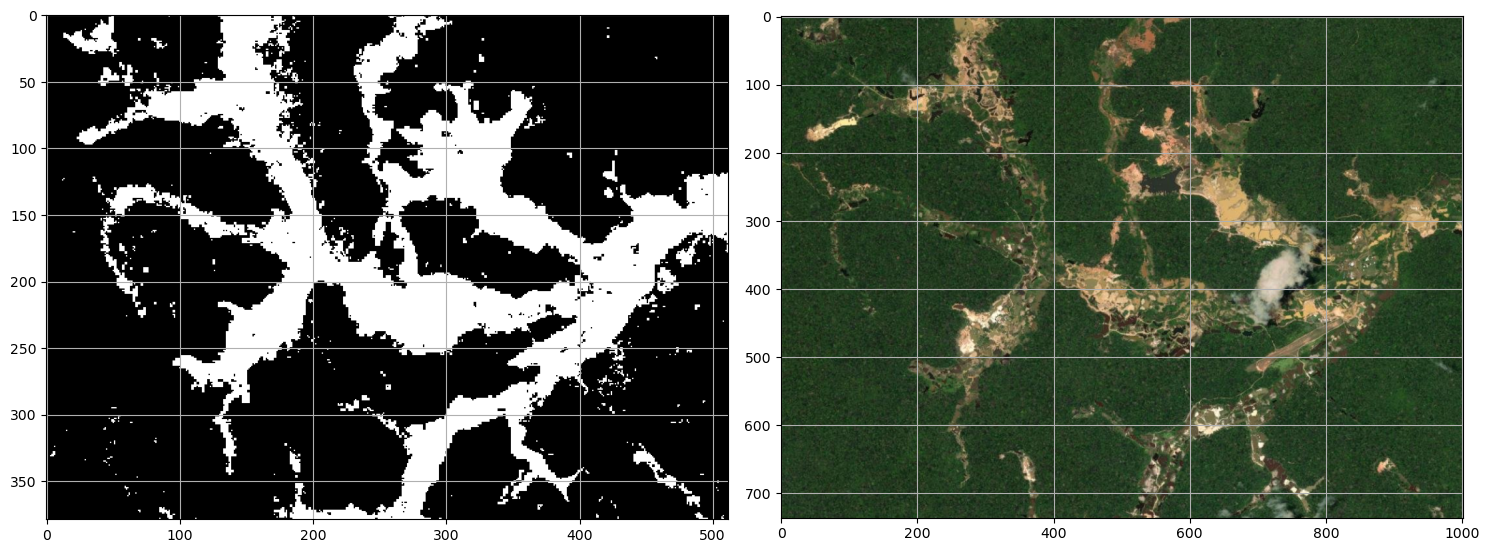

In [85]:
# lets compare the classification to a visual RGB of the area to see
# where the classification is not working so well

fig,axs = plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(output_v1)
display_esri_2022_basemap(axs[1])
[i.grid() for i in axs]
plt.tight_layout()

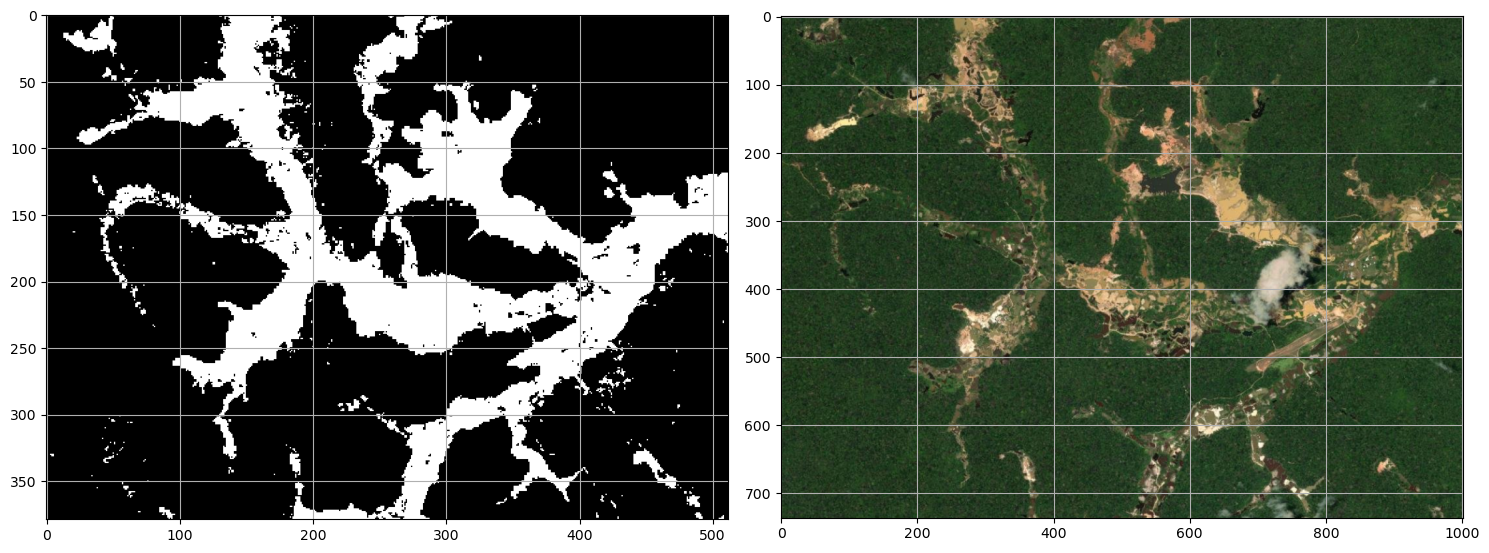

In [86]:
# now lets see the output from Model 2
output_v2, output_v2_fp, output_v2_mp = apply_ml_classifier(xa_complete_scene, ml_model_v2)

fig,axs = plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(output_v2)
display_esri_2022_basemap(axs[1])
[i.grid() for i in axs]
plt.tight_layout()

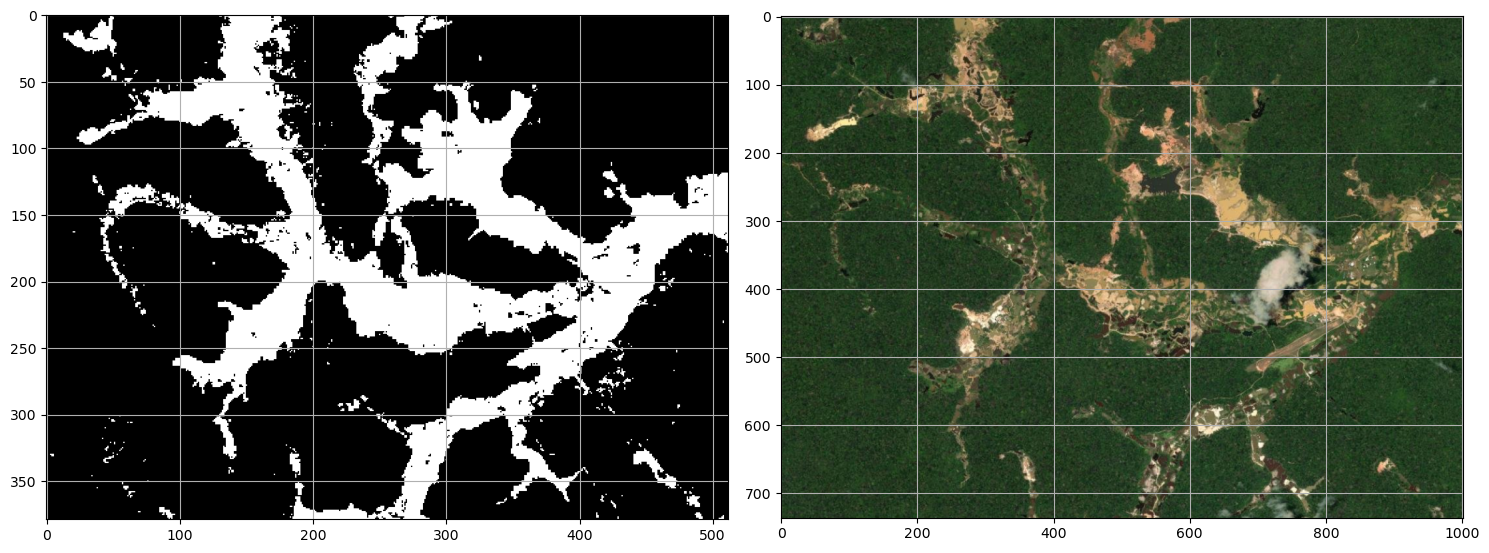

In [87]:
# Finally, lets see how well model 3 works
output_v3, output_v3_fp, output_v3_mp = apply_ml_classifier(xa_complete_scene, ml_model_v3)

fig,axs = plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(output_v2)
display_esri_2022_basemap(axs[1])
[i.grid() for i in axs]
plt.tight_layout()

Text(0.5, 1.0, 'Model 3 Classification')

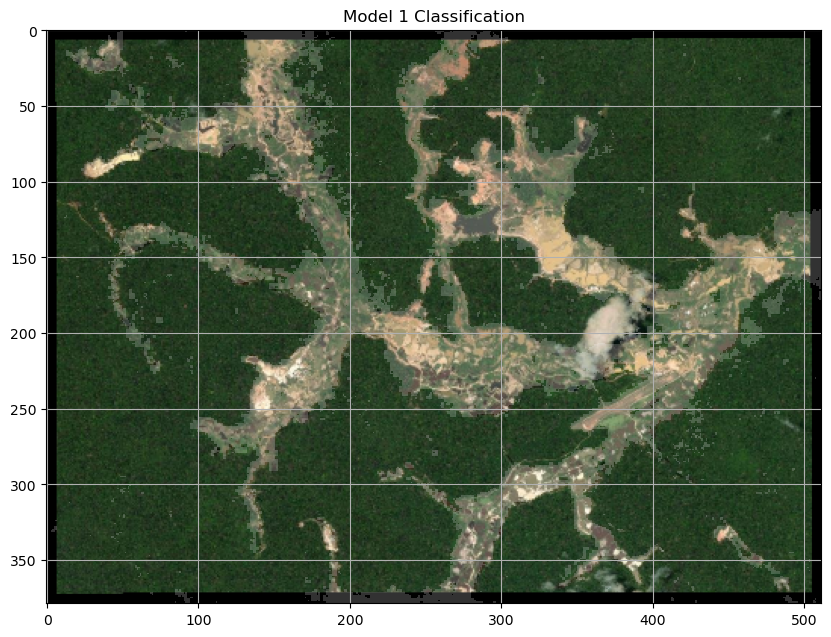

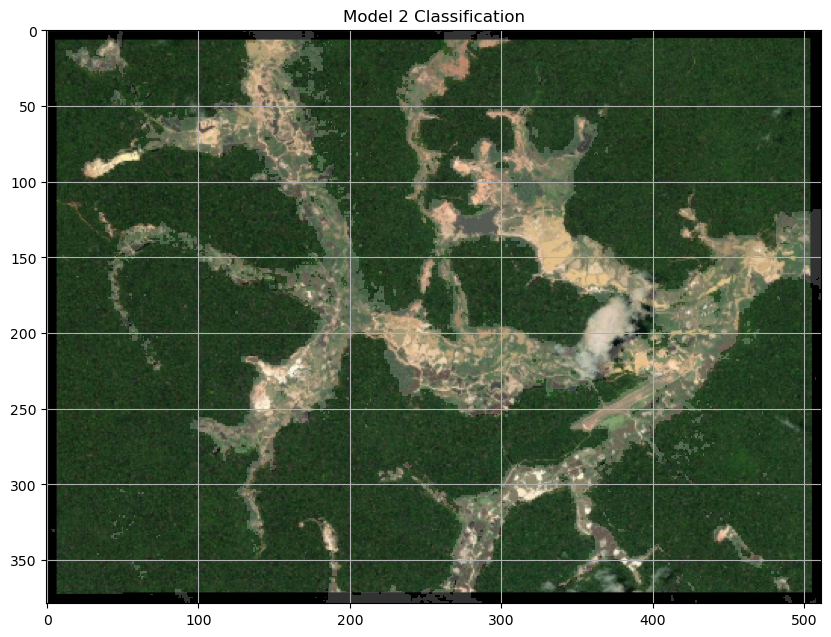

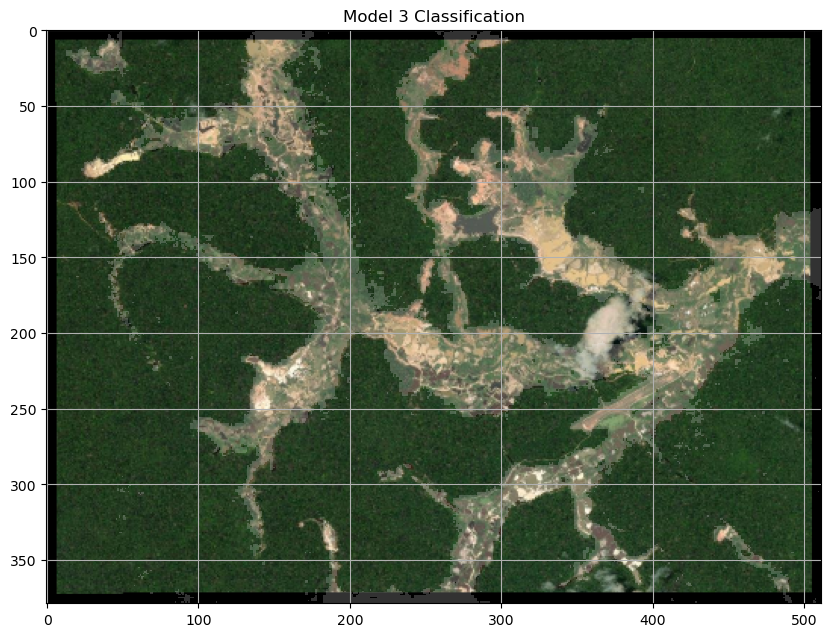

In [88]:
# we also have this helpful function to plot the classification over the basemap 
overlay_output_on_esri_2022_basemap(output_v1)
plt.title('Model 1 Classification')
overlay_output_on_esri_2022_basemap(output_v2)
plt.title('Model 2 Classification')
overlay_output_on_esri_2022_basemap(output_v3)
plt.title('Model 3 Classification')

Visually, we can see that most of the classification works well with all models. Model 1 has allot more 'Salt and Pepper effects', which are where there are individual pixels being miscalssified in homogenous areas. These are found in the top right of the image and bottom left. But all classifications have an issue around in the region of [260,410] in the array, where there is 'Mining' classification found where there should be forest landcover. These are regions where cloudcover has not been correctly masked out and is artifically increasing the band reflectance. This can be resolved by reducing the cloudmask critical threshold parameter. Also, more robust models like XGBoost are less liklely to missclassify like this, which you can see in that 'output_v3' has less of these effects than 'output_v1'<br><br>

Finally, lets compile data for 2019 and compare the classification accuracy as well as the landcover change in the region.

In [89]:
s1_data_complete_scene_2019 = compile_sentinel_1_stacks('/data/un_suriname_demo/datacube/',
                                       s1_bands, '2019', file_to_project_onto)

s2_data_complete_scene_2019 = compile_sentinel_2_stacks('/data/un_suriname_demo/datacube/',
                                       s2_bands, '2019', file_to_project_onto)

cloudmask_complete_scene_2019 = find_sentinel_2_cloudmask(s2_data_complete_scene_2019, 
                                             critical_cloud_threshold = cloudmask_threshold)

for band in s2_bands:
    s2_data_complete_scene_2019[band][cloudmask_complete_scene_2019] = np.nan
    
generate_spectral_indexes(s2_data_complete_scene_2019)

s1_composites_complete_scene_2019 = derive_composites(s1_data_complete_scene_2019)
s2_composites_complete_scene_2019 = derive_composites(s2_data_complete_scene_2019)

In [90]:
data_complete_scene_2019 = {** s1_composites_complete_scene_2019, ** s2_composites_complete_scene_2019}
xa_complete_scene_2019 = np.array(list(data_complete_scene_2019.values()))

In [91]:
output_v3_2019, output_v3_fp_2019, output_v3_mp_2019 = apply_ml_classifier(xa_complete_scene_2019, ml_model_v3)

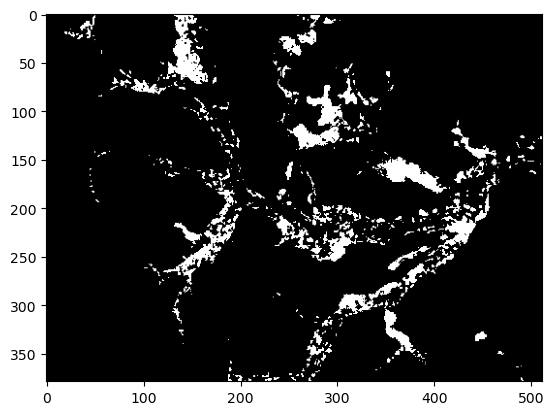

In [92]:
plt.imshow(output_v3_2019)

As we can see from the above plot, the classifier is not quite working as we would expect, where there is allot less mining activity that expected. This is likely due to changes in the reflectance data being higher in 2022, so the model is expecting values in the same range. This means, to optimize the model and make it robust inter-annually, we need to build a classifier that only uses the spectral indexes, as these are normalised and will have the same behaviour each year for regions of no change.

In [93]:
# we will only use the following features to train this model
print (feature_names[-9:])

['NDVI_mean' 'NDVI_maximum' 'NDVI_minimum' 'NDWI_mean' 'NDWI_maximum'
 'NDWI_minimum' 'BSI_mean' 'BSI_maximum' 'BSI_minimum']


In [94]:
xt_subset = xt[:,-9:]
xv_subset = xv[:,-9:]

ml_model_v4 = xgboost.XGBClassifier()
ml_model_v4.fit(xt_subset,yt)

# check its accuracy
print (ml_model_v4.score(xv_subset,yv))

[10:27:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9838075410594495


In [97]:
# subset the features used for ml_model_v4
xa_complete_scene_2022_subfeatures = xa_complete_scene[-9:]
xa_complete_scene_2019_subfeatures = xa_complete_scene_2019[-9:]
output_v4_2022, output_v4_fp_2022, output_v4_mp_2022 = apply_ml_classifier(xa_complete_scene_2022_subfeatures, ml_model_v4)
output_v4_2019, output_v4_fp_2019, output_v4_mp_2019 = apply_ml_classifier(xa_complete_scene_2019_subfeatures, ml_model_v4)

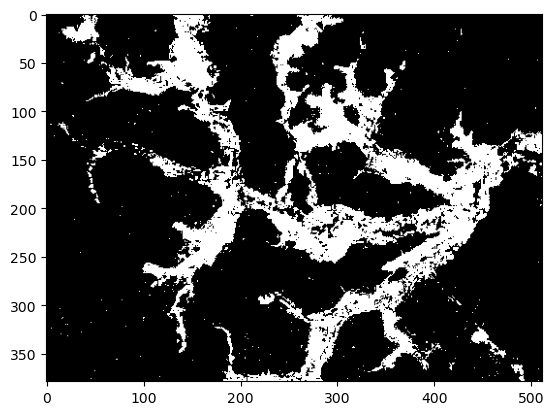

In [98]:
plt.imshow(output_v4_2019)

We can now find regions where there has been landcover change, simply by subtracting one output from another.

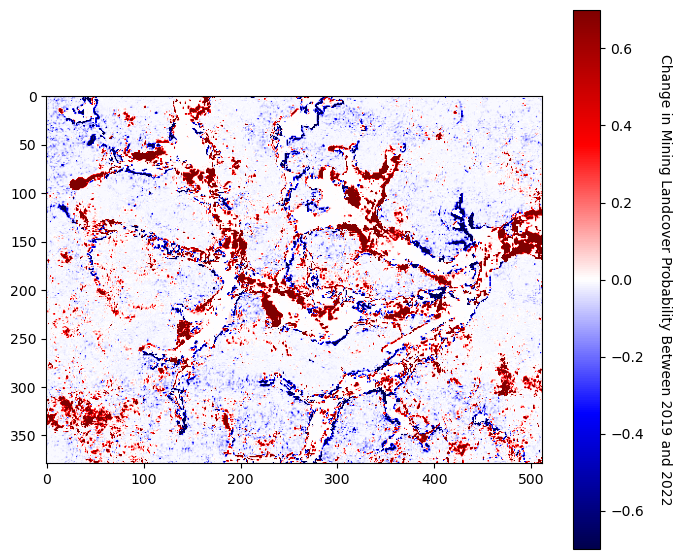

In [99]:
plt.figure(figsize=(8,7))
plt.imshow(output_v4_mp_2022 - output_v4_mp_2019,cmap='seismic',
           vmin=-0.7,vmax=0.7)
bar = plt.colorbar()
bar.set_label('Change in Mining Landcover Probability Between 2019 and 2022',
             rotation=270,labelpad=20)

You can visually observe these changes by using the following link:<br>https://livingatlas.arcgis.com/wayback/#active=14765&ext=-55.63387,4.83819,-55.56650,4.88338&localChangesOnly=true<br>
Select different images on the left hand side and see where mining distribution has changed in the area in the different available images.